# Imports

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

In [43]:
df = pd.read_csv('life_expectancy.csv')

# Data analysis and exploration

In [44]:
# Helper function to analyse the data
def data_explorer(df,max_columns=60,max_rows = 20, display_func=display):
  if not isinstance(df, pd.DataFrame):df=pd.DataFrame(df)

  pd.set_option('display.max_columns',max_columns)
  pd.set_option('display.max_rows', max_rows)

  break_line="------------------------------------------------"

  print('data sample:')
  display_func(df)
  print(break_line)

  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', None)
  print('data info:')
  display_func(df.info())
  print(break_line)

  # Check the general structure of the dataset
  print('data description:')
  display_func(df.describe())
  
  print(break_line)

  print('data nan check:')
  display_func(df.isna().sum())
  pd.set_option('display.max_columns',max_columns)
  pd.set_option('display.max_rows', max_rows)

In [ ]:
data_explorer(df)

In [50]:
# Helper function to plot histograms for the data
def data_histogram(df,figsize=(10, 15),histogram_fig_col=None,gridspec_kw={'wspace': 0.1, 'hspace': 0.1}):
   # Select numeric columns (integer and float types)
   numeric_columns = df.select_dtypes(include=['number']).columns

   # Calculate the square root of the number of plots to find the closest square layout
   if histogram_fig_col is None:
    cols = int(math.sqrt(len(numeric_columns)))
   else:
    cols = histogram_fig_col
   rows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

   fig, axes = plt.subplots(rows, cols, figsize=figsize,constrained_layout=True,gridspec_kw=gridspec_kw)
   fig_width, fig_height = fig.get_size_inches()

   # Flatten the axes array for easy iteration
   axes = axes.flatten()

   # Plotting each attribute in the grid
   for i, column in enumerate(numeric_columns):
        sns.histplot(df[column], kde=True, ax=axes[i])

   # Remove any unused subplots
   for j in range(i + 1, len(axes)):
       fig.delaxes(axes[j])

   axes.reshape(rows, cols)
   plt.show()

In [ ]:
data_histogram(df,figsize=(20, 60),histogram_fig_col=3)

In [52]:
df.columns = df.columns.str.lower()

# Dictionary mapping old column names to new column names for better habdnling the data
column_rename_dict = {
    'country': 'country',
    'year': 'year',
    'mean years of schooling, female (years)': 'mean_years_of_schooling_female',
    'share of seats in parliament, male (% held by men)': 'share_of_male_seats_in_parliament',
    'mean years of schooling (years)': 'mean_years_of_schooling',
    'inequality in income': 'income_inequality',
    'carbon dioxide emissions per capita (production) (tonnes)': 'co2_emissions_per_capita_tonnes',
    'expected years of schooling, male (years)': 'expected_years_of_schooling_male',
    'expected years of schooling (years)': 'expected_years_of_schooling',
    'labour force participation rate, female (% ages 15 and older)': 'female_labour_force_participation_rate',
    'population with at least some secondary education, female (% ages 25 and older)': 'female_population_with_some_secondary_education',
    'expected years of schooling, female (years)': 'expected_years_of_schooling_female',
    'adolescent birth rate (births per 1,000 women ages 15-19)': 'adolescent_birth_rate_per_1000_women_ages_15_19',
    'material footprint per capita (tonnes)': 'material_footprint_per_capita_tonnes',
    'mean years of schooling, male (years)': 'mean_years_of_schooling_male',
    'population with at least some secondary education, male (% ages 25 and older)': 'male_population_with_some_secondary_education',
    'share of seats in parliament, female (% held by women)': 'share_of_female_seats_in_parliament',
    'inequality in eduation': 'education_inequality',
    'gender development index (value)': 'gender_development_index',
    'coefficient of human inequality': 'coefficient_of_human_inequality',
    'labour force participation rate, male (% ages 15 and older)': 'male_labour_force_participation_rate',
    'human development index (value)': 'human_development_index',
    'gross national income per capita (2017 ppp$)': 'gross_national_income_per_capita_2017_ppp',
    'total population, as of 1 january (thousands)': 'total_population_as_of_january_1st_thousands',
    'total population, as of 1 july (thousands)': 'total_population_as_of_july_1st_thousands',
    'male population, as of 1 july (thousands)': 'male_population_as_of_july_1st_thousands',
    'female population, as of 1 july (thousands)': 'female_population_as_of_july_1st_thousands',
    'population density, as of 1 july (persons per square km)': 'population_density_as_of_july_1st_persons_per_square_km',
    'population sex ratio, as of 1 july (males per 100 females)': 'population_sex_ratio_as_of_july_1st_males_per_100_females',
    'median age, as of 1 july (years)': 'median_age_as_of_july_1st_years',
    'natural change, births minus deaths (thousands)': 'natural_change_births_minus_deaths_thousands',
    'rate of natural change (per 1,000 population)': 'rate_of_natural_change_per_1000_population',
    'population change (thousands)': 'population_change_thousands',
    'population growth rate (percentage)': 'population_growth_rate_percentage',
    'population annual doubling time (years)': 'population_annual_doubling_time_years',
    'births (thousands)': 'births_thousands',
    'births by women aged 15 to 19 (thousands)': 'births_by_women_aged_15_to_19_thousands',
    'crude birth rate (births per 1,000 population)': 'crude_birth_rate_births_per_1000_population',
    'total fertility rate (live births per woman)': 'total_fertility_rate_live_births_per_woman',
    'net reproduction rate (surviving daughters per woman)': 'net_reproduction_rate_surviving_daughters_per_woman',
    'mean age childbearing (years)': 'mean_age_of_childbearing_years',
    'sex ratio at birth (males per 100 female births)': 'sex_ratio_at_birth_males_per_100_female_births',
    'total deaths (thousands)': 'total_deaths_thousands',
    'male deaths (thousands)': 'male_deaths_thousands',
    'female deaths (thousands)': 'female_deaths_thousands',
    'crude death rate (deaths per 1,000 population)': 'crude_death_rate_deaths_per_1000_population',
    'life expectancy at birth, both sexes (years)': 'life_expectancy_at_birth_both_sexes_years',
    'live births surviving to age 1 (thousands)': 'live_births_surviving_to_age_1_thousands',
    'net number of migrants (thousands)': 'net_number_of_migrants_thousands',
    'net migration rate (per 1,000 population)': 'net_migration_rate_per_1000_population'
}

In [53]:
df_new = df.copy()

# Rename columns using the mapping
df_new = df_new.rename(columns=column_rename_dict, errors='raise')

# Drop columns with more than 50% missing values
missing_percentage = df_new.isnull().mean() * 100
cols_to_drop = missing_percentage[missing_percentage > 50].index
df_new.drop(columns=cols_to_drop, inplace=True)

# Drop rows where the target variable is missing
df_new.dropna(subset=['life_expectancy_at_birth_both_sexes_years'], inplace=True)

# Label encode 'country' to 'country_id'
label_encoder = LabelEncoder()
df_new['country_id'] = label_encoder.fit_transform(df_new['country'])

# Define features and target
y_col = 'life_expectancy_at_birth_both_sexes_years'
x_col = [col for col in df_new.columns if col not in [y_col, 'country', 'country_id']]

X = df_new[x_col]
y = df_new[y_col]
groups = df_new['country_id']

# Perform group-wise train-test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test = X.iloc[test_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

# Impute missing values in numerical columns using the mean
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

imputer = SimpleImputer(strategy='mean')
X_train[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])

# Problem 2

### a) Identifying the variable with the strongest linear relationship with LEB

In [55]:
# Concatenate X_train and y_train to form a complete training dataframe
df_train = pd.concat([X_train, y_train], axis=1)

# Compute the correlation matrix
corr_matrix = df_train.corr()

# Get the correlations with the target variable
target_correlations = corr_matrix['life_expectancy_at_birth_both_sexes_years'].drop('life_expectancy_at_birth_both_sexes_years')

# Find the variable with the highest absolute correlation with the target variable
max_corr_variable = target_correlations.abs().idxmax()
max_corr_value = target_correlations[max_corr_variable]

print(f"The variable with the strongest linear relationship with LEB is '{max_corr_variable}' with a Pearson correlation coefficient of {max_corr_value:.4f}")

The variable with the strongest linear relationship with LEB is 'human_development_index' with a Pearson correlation coefficient of 0.9188


### b) Constructing a Single-variable Linear Model

Intercept: 35.1351
Coefficient for 'human_development_index': 50.7742
Coefficient of Determination (R^2): 0.8442


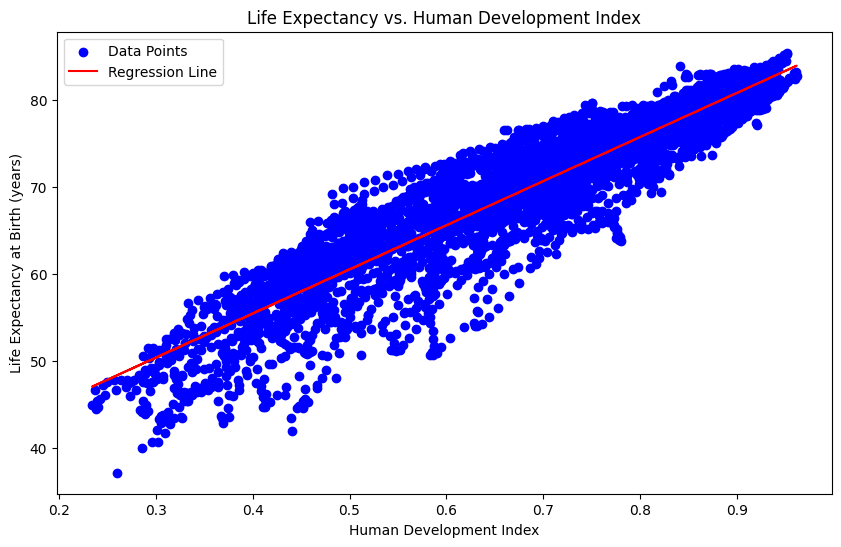

In [58]:
# Extract the variable and target from the training data
X_var_train = X_train[[max_corr_variable]]
y_train_values = y_train

# Fit the linear regression model
model = LinearRegression()
model.fit(X_var_train, y_train_values)

# Get the coefficients
intercept = model.intercept_
coefficient = model.coef_[0]
r_squared = model.score(X_var_train, y_train_values)

print(f"Intercept: {intercept:.4f}")
print(f"Coefficient for '{max_corr_variable}': {coefficient:.4f}")
print(f"Coefficient of Determination (R^2): {r_squared:.4f}")

# Plotting the scatter plot with regression line
plt.figure(figsize=(10,6))
plt.scatter(X_var_train, y_train_values, color='blue', label='Data Points')
plt.plot(X_var_train, model.predict(X_var_train), color='red', label='Regression Line')
plt.xlabel(max_corr_variable.replace('_', ' ').title())
plt.ylabel('Life Expectancy at Birth (years)')
plt.title('Life Expectancy vs. ' + max_corr_variable.replace('_', ' ').title())
plt.legend()
plt.savefig("LEB_HDI.pdf", format='pdf')
plt.show()

### c) Evaluating the model on the test set

In [57]:
# Extract the predictor variable from the test set
X_var_test = X_test[[max_corr_variable]]
y_test_values = y_test

# Make predictions
y_pred = model.predict(X_var_test)

# Calculate the correlation between the predicted and actual LEB
correlation_matrix = np.corrcoef(y_pred, y_test_values)
correlation = correlation_matrix[0,1]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_values, y_pred)

print(f"Correlation between predicted and actual LEB: {correlation:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Correlation between predicted and actual LEB: 0.9205
Mean Squared Error (MSE): 15.2785


# Problem 3

In [59]:
# Get numerical columns excluding HDI variable
variable_to_exclude = ['human_development_index']
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
variables_to_consider = [col for col in numerical_cols if col not in variable_to_exclude]

# Initialize a list to store correlation results
correlation_list = []

# Compute Pearson and Spearman correlations for each variable
for col in variables_to_consider:
    X_var = X_train[col]
    y_var = y_train
    pearson_corr, _ = pearsonr(X_var, y_var)
    spearman_corr, _ = spearmanr(X_var, y_var)
    correlation_list.append({
        'variable': col,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr
    })

# Create a dataframe from the correlation list
correlation_df = pd.DataFrame(correlation_list)

# Calculate the absolute correlations and the difference
correlation_df['abs_pearson_corr'] = correlation_df['pearson_corr'].abs()
correlation_df['abs_spearman_corr'] = correlation_df['spearman_corr'].abs()
correlation_df['corr_diff'] = correlation_df['abs_spearman_corr'] - correlation_df['abs_pearson_corr']

# Sort variables by the largest difference between Spearman and Pearson correlations
correlation_df.sort_values(by='corr_diff', ascending=False, inplace=True)

# Display the top variables
print("Variables with the largest difference between Spearman and Pearson correlations:")
print(correlation_df.head())

Variables with the largest difference between Spearman and Pearson correlations:
                                        variable  pearson_corr  spearman_corr  \
31       births_by_women_aged_15_to_19_thousands     -0.116025      -0.478762   
25  natural_change_births_minus_deaths_thousands     -0.078438      -0.404827   
4                co2_emissions_per_capita_tonnes      0.447551       0.742314   
30                              births_thousands     -0.048339      -0.281809   
41      live_births_surviving_to_age_1_thousands     -0.044235      -0.271484   

    abs_pearson_corr  abs_spearman_corr  corr_diff  
31          0.116025           0.478762   0.362737  
25          0.078438           0.404827   0.326389  
4           0.447551           0.742314   0.294763  
30          0.048339           0.281809   0.233471  
41          0.044235           0.271484   0.227248  


In [61]:
# Select the variable with the highest corr_diff
candidate_variable = correlation_df.iloc[0]['variable']

print(f"Selected Variable: {candidate_variable}")
print(f"Pearson Correlation: {correlation_df.iloc[0]['pearson_corr']:.4f}")
print(f"Spearman Correlation: {correlation_df.iloc[0]['spearman_corr']:.4f}")

Selected Variable: births_by_women_aged_15_to_19_thousands
Pearson Correlation: -0.1160
Spearman Correlation: -0.4788


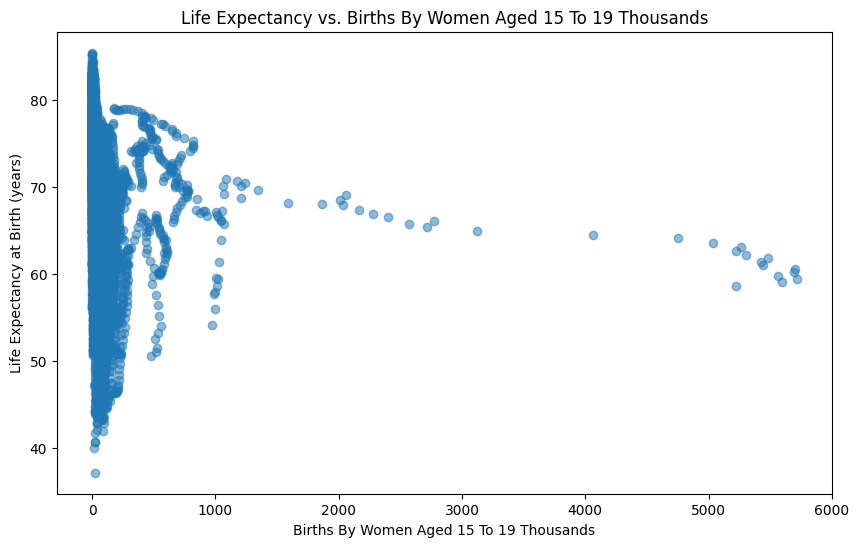

In [85]:
# Scatter plot of the variable before the transformation
plt.figure(figsize=(10, 6))
plt.scatter(X_train[candidate_variable], y_train, alpha=0.5)
plt.xlabel(candidate_variable.replace('_', ' ').title())
plt.ylabel('Life Expectancy at Birth (years)')
plt.title(f'Life Expectancy vs. {candidate_variable.replace("_", " ").title()}')
plt.savefig("births_leb_before.pdf", format='pdf')
plt.show()

In [64]:
def find_best_transformation(X_var, y_var):
    transformations = {
        'original': X_var,
        'log': np.log(X_var + 1),     # Add 1 to avoid log(0)
        'sqrt': np.sqrt(X_var + 1),   # Add 1 to avoid sqrt(0)
        'inverse': 1 / (X_var + 1e-6), # Add small value to avoid division by zero
        'square': X_var ** 2,
        'cube': X_var ** 3,
    }
    results = []
    for name, transformed_var in transformations.items():
        # Remove infinite or NaN values
        mask = ~np.isinf(transformed_var) & ~np.isnan(transformed_var)
        transformed_var = transformed_var[mask]
        y_valid = y_var[mask]
        pearson_corr, _ = pearsonr(transformed_var, y_valid)
        results.append({'transformation': name, 'pearson_corr': pearson_corr})
    results_df = pd.DataFrame(results)
    return results_df

# Apply transformations
X_var = X_train[candidate_variable]
y_var = y_train

transformation_results = find_best_transformation(X_var, y_var)
transformation_results['abs_pearson_corr'] = transformation_results['pearson_corr'].abs()

# Display the results
print("Transformation Results:")
print(transformation_results)


Transformation Results:
  transformation  pearson_corr  abs_pearson_corr
0       original     -0.116025          0.116025
1            log     -0.445661          0.445661
2           sqrt     -0.286161          0.286161
3        inverse      0.141019          0.141019
4         square     -0.053405          0.053405
5           cube     -0.050038          0.050038


In [65]:
# Find the transformation with the highest absolute Pearson correlation
best_transformation = transformation_results.loc[transformation_results['abs_pearson_corr'].idxmax()]

print(f"Best Transformation: {best_transformation['transformation']}")
print(f"Pearson Correlation after Transformation: {best_transformation['pearson_corr']:.4f}")

Best Transformation: log
Pearson Correlation after Transformation: -0.4457


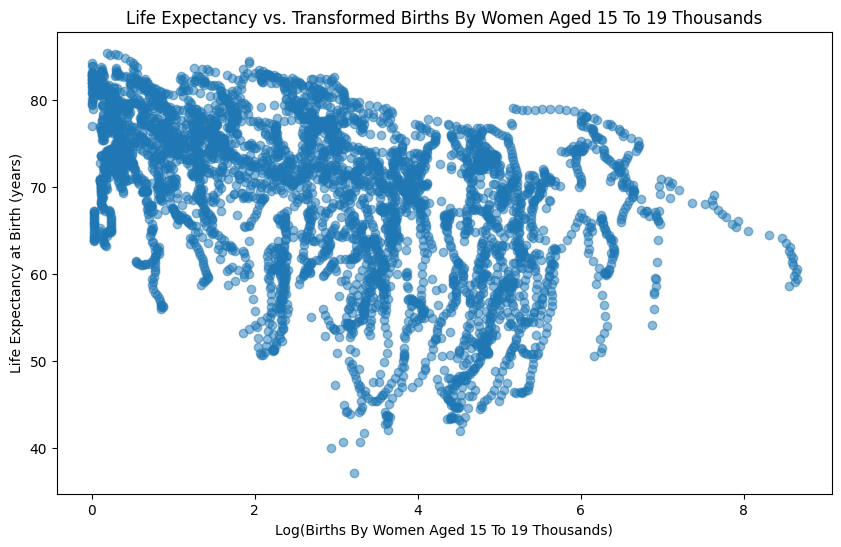

In [86]:
# Apply the best transformation
transformed_X_var = np.log(X_var + 1)

# Plot the transformed variable against the target
plt.figure(figsize=(10, 6))
plt.scatter(transformed_X_var, y_var, alpha=0.5)
plt.xlabel(f"{best_transformation['transformation'].title()}({candidate_variable.replace('_', ' ').title()})")
plt.ylabel('Life Expectancy at Birth (years)')
plt.title(f'Life Expectancy vs. Transformed {candidate_variable.replace("_", " ").title()}')
plt.savefig('births_leb_after.pdf', format='pdf')
plt.show()


# Problem 4

In [68]:
# Exclude the variable from Problem 2
variable_to_exclude = 'human_development_index'
X_train = X_train.drop(columns=[variable_to_exclude], errors='ignore')
X_test = X_test.drop(columns=[variable_to_exclude], errors='ignore')

# Include the transformed variable from Problem 3
transformed_variable = 'births_by_women_aged_15_to_19_thousands'
X_train['log_' + transformed_variable] = np.log(X_train[transformed_variable] + 1)
X_test['log_' + transformed_variable] = np.log(X_test[transformed_variable] + 1)


In [69]:
# Compute Pearson correlations between features and target
correlations = X_train.corrwith(y_train)

# Convert to dataframe for better visualization
correlations_df = correlations.to_frame().reset_index()
correlations_df.columns = ['feature', 'pearson_corr']
correlations_df['abs_corr'] = correlations_df['pearson_corr'].abs()

# Sort features by absolute correlation
correlations_df.sort_values(by='abs_corr', ascending=False, inplace=True)

# Display top features
print("Top features based on Pearson correlation with the target variable:")
print(correlations_df.head(10))


Top features based on Pearson correlation with the target variable:
                                              feature  pearson_corr  abs_corr
32        crude_birth_rate_births_per_1000_population     -0.865301  0.865301
33         total_fertility_rate_live_births_per_woman     -0.844886  0.844886
6                         expected_years_of_schooling      0.808683  0.808683
9                  expected_years_of_schooling_female      0.804915  0.804915
24                    median_age_as_of_july_1st_years      0.792664  0.792664
10    adolescent_birth_rate_per_1000_women_ages_15_19     -0.790072  0.790072
34  net_reproduction_rate_surviving_daughters_per_...     -0.780960  0.780960
5                    expected_years_of_schooling_male      0.769783  0.769783
3                             mean_years_of_schooling      0.739766  0.739766
1                      mean_years_of_schooling_female      0.737394  0.737394


In [73]:
from sklearn.model_selection import cross_val_score

# Initialize variables
best_features = []
remaining_features = [col for col in X_train.columns if col != 'country_id']
best_mse = float('inf')

while remaining_features:
    mse_with_features = []
    for feature in remaining_features:
        current_features = best_features + [feature]
        X = X_train[current_features]
        y = y_train
        model = LinearRegression()
        # Use 5-fold cross-validation
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        mse = -scores.mean()
        mse_with_features.append((feature, mse))
    # Find feature with the lowest MSE
    feature, mse = min(mse_with_features, key=lambda x: x[1])
    if mse < best_mse:
        best_mse = mse
        best_features.append(feature)
        remaining_features.remove(feature)
        print(f"Added feature '{feature}' with MSE: {mse:.4f}")
    else:
        # Stop if no improvement
        break


Added feature 'crude_birth_rate_births_per_1000_population' with MSE: 20.7273
Added feature 'crude_death_rate_deaths_per_1000_population' with MSE: 10.7022
Added feature 'median_age_as_of_july_1st_years' with MSE: 4.2557
Added feature 'population_sex_ratio_as_of_july_1st_males_per_100_females' with MSE: 3.7174
Added feature 'net_reproduction_rate_surviving_daughters_per_woman' with MSE: 3.2625
Added feature 'year' with MSE: 3.1526
Added feature 'co2_emissions_per_capita_tonnes' with MSE: 2.9810
Added feature 'expected_years_of_schooling' with MSE: 2.8394
Added feature 'adolescent_birth_rate_per_1000_women_ages_15_19' with MSE: 2.7907
Added feature 'male_deaths_thousands' with MSE: 2.7704
Added feature 'female_labour_force_participation_rate' with MSE: 2.7529
Added feature 'population_density_as_of_july_1st_persons_per_square_km' with MSE: 2.7415
Added feature 'total_fertility_rate_live_births_per_woman' with MSE: 2.7290
Added feature 'expected_years_of_schooling_male' with MSE: 2.7252


In [81]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
X = X_train[best_features]
y = y_train
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]

print("\nSelected features after RFE:")
for feature in selected_features:
    print(f"- {feature}")


Selected features after RFE:
- crude_death_rate_deaths_per_1000_population
- median_age_as_of_july_1st_years
- net_reproduction_rate_surviving_daughters_per_woman


In [82]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = LinearRegression()
model.fit(X_train_selected, y_train)

# Training performance
r_squared = model.score(X_train_selected, y_train)
print(f"R² on Training Set: {r_squared:.4f}")

# Test performance
y_pred = model.predict(X_test_selected)
test_mse = mean_squared_error(y_test, y_pred)
test_correlation = np.corrcoef(y_test, y_pred)[0, 1]

print(f"Test Set MSE: {test_mse:.4f}")
print(f"Test Set Pearson Correlation: {test_correlation:.4f}")


R² on Training Set: 0.9511
Test Set MSE: 3.2690
Test Set Pearson Correlation: 0.9835
